<a href="https://colab.research.google.com/github/Andy-Lewis-Sapner/EML_EcoCoders/blob/main/HW3/EcoKishonProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Enums and Constants

https://github.com/Andy-Lewis-Sapner/EML_EcoCoders

https://en.wikipedia.org/api/rest_v1/page/summary/{title}

In [108]:
!pip install gradio pykrige -q

In [109]:
from datetime import datetime
from enum import Enum
import folium
import geopandas as gpd
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
from pykrige.ok import OrdinaryKriging
import requests
import seaborn as sns
from shapely.geometry import Point
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

In [110]:
kishon_occurences_data_file = "https://github.com/Andy-Lewis-Sapner/EML_EcoCoders/raw/main/Data/gbif_kishon_data_occurences.csv"
kishon_measurements_file = "https://github.com/Andy-Lewis-Sapner/EML_EcoCoders/raw/main/Data/KishonRiverMonitoringReports.xlsx"
pca_data_file = "https://github.com/Andy-Lewis-Sapner/EML_EcoCoders/raw/main/Data/MeasurmentsAndIndividualsMeanValues.csv"
monitoring_reports_data_file = "https://github.com/Andy-Lewis-Sapner/EML_EcoCoders/raw/main/Data/KishonRiverMonitoringReports.xlsx"
measurments_and_individuals_file = "https://github.com/Andy-Lewis-Sapner/EML_EcoCoders/raw/main/Data/MeasurmentsAndIndividuals.csv"

In [111]:
station_coords = {
    'morad_reservoir_kfar_baruch': (35.193290585018204, 32.63799421872744),
    'quarry_station_jalama': (35.0988160806192, 32.72607628851692),
    'bridge_iri_yagur': (35.065171162350055, 32.75927717927157),
    'gypsum_mountain': (35.0691103835696, 32.777568354869544),
    'histadrut_bridge': (35.04857038220264, 32.79873407157874),
    'julius_simon_bridge': (35.03488553907516, 32.8016502054031),
    'stone_pier': (35.0285340685954, 32.808467653058855),
}

In [112]:
class Month(Enum):
  Jan = 1
  Feb = 2
  Mar = 3
  Apr = 4
  May = 5
  Jun = 6
  Jul = 7
  Aug = 8
  Sep = 9
  Oct = 10
  Nov = 11
  Dec = 12

class Measurement(Enum):  # strings have to be as writen in the csv file (except of total populations)
  Total_populations = "total_populations"
  Specific_electrical_conductivity = "specific_electrical_conductivity"
  ph = "ph_value"
  Dissolved_oxygen = "dissolved_oxygen_saturation_percentage"
  Temperature = "temperature"
  Opacity = "opacity"
  Coliform_bacteria = "coliform_bacteria"

measurements_size = len(Measurement)

class Color(Enum):
  Red = "red"
  Green = "green"
  Blue = "blue"
  Yellow = "yellow"
  Purple = "purple"
  Orange = "orange"
  Grey = "grey"
  Brown = "brown"
  Pink = "pink"

class Station(Enum):
  morad_reservoir_kfar_baruch = "morad_reservoir_kfar_baruch"
  quarry_station_jalama = "quarry_station_jalama"
  bridge_iri_yagur = "bridge_iri_yagur"
  gypsum_mountain = "gypsum_mountain"
  histadrut_bridge = "histadrut_bridge"
  julius_simon_bridge = "julius_simon_bridge"
  stone_pier = "stone_pier"

# setting enums as lists for later use
measurement_list = list(Measurement)
color_list = list(Color)
station_list = list(Station)

# Data Analysis


Show Datasets, PCA and Kriging

## Logic

In [113]:
kishon_occurences = pd.read_csv(kishon_occurences_data_file)
kishon_measurements = pd.read_excel(kishon_measurements_file)

In [114]:
measurements_needed = ['specific_electrical_conductivity', 'opacity', 'coliform_bacteria', 'dissolved_oxygen_saturaion_percentage', 'opacity', 'ph_value', 'specific_electrical_conductivity', 'temperature']

# Filter the dataframe to include only 'specific_electrical_conductivity' and 'opacity'
# filtered_df = kishon_measurements[kishon_measurements['measurement_type'].isin(['specific_electrical_conductivity', 'opacity', 'coliform_bacteria'])].copy()
filtered_df = kishon_measurements[kishon_measurements['measurement_type'].isin(measurements_needed)].copy()

# Extract year and month from the 'measurement_date' column
filtered_df['year'] = pd.to_datetime(filtered_df['measurement_date']).dt.year
filtered_df['month'] = pd.to_datetime(filtered_df['measurement_date']).dt.month

# Define the list of station columns
station_columns = ['morad_reservoir_kfar_baruch', 'quarry_station_jalama', 'bridge_iri_yagur', 'gypsum_mountain', 'histadrut_bridge', 'julius_simon_bridge', 'stone_pier']

# Melt the dataframe to have station names as a column
melted_df = filtered_df.melt(
    id_vars=['year', 'month', 'measurement_type'],
    value_vars=station_columns,
    var_name='station',
    value_name='measurement_value'
)

# Group by year, month, measurement type, and station, and calculate the mean
mean_measurements = melted_df.groupby(['year', 'month', 'measurement_type'])['measurement_value'].mean().reset_index()

# Pivot the table to have measurement_type as columns
mean_measurements_pivot = mean_measurements.pivot_table(
    index=['year', 'month'],
    columns='measurement_type',
    values='measurement_value'
).reset_index()

# Create the new dataframe with the calculated means
measurements_kishon = mean_measurements_pivot
kishon_occurences_per_year_month = kishon_occurences.groupby(['year', 'month'])['individualCount'].sum().reset_index()
merged_df = measurements_kishon.merge(kishon_occurences_per_year_month, on=['year', 'month'], how='inner')

###PCA

In [115]:
# Load Data
# eco_data = pd.read_csv(pca_data_file)
eco_data = merged_df.copy()
eco_data_dates = eco_data['year'].astype(int).astype(str) + '-' + eco_data['month'].astype(int).astype(str)
eco_data.insert(0, 'Date', eco_data_dates)
# Dropping rows with NaN values before PCA
eco_data = eco_data[~eco_data.isnull().any(axis=1)]

# Align eco_data_dates with the index of eco_data after dropping NaNs
eco_data_dates_aligned = eco_data['Date']

# Drop original year and month columns as 'Date' is now present
eco_data = eco_data.drop(columns=['year', 'month'])

In [116]:
# Standardize Data
X = eco_data.iloc[:, 1:].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [117]:
# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

In [118]:
# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(X.shape[1])])
pca_df['Date'] = eco_data_dates

In [119]:
# Get the loadings (correlation between variables and principal components)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(X.shape[1])])
loadings_df['Variable'] = eco_data.columns[1:]

In [120]:
feature_names = eco_data.columns[1:]
correlation_matrix = eco_data.iloc[:, 1:].corr()
explained_variance = pca.explained_variance_ratio_ * 100

In [121]:
def biplot_pc1_pc2():
  biplot_fig = plt.figure(figsize=(12, 10))
  # Use the aligned eco_data_dates for annotation
  plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100, alpha=0.7)
  for i, site in enumerate(eco_data_dates_aligned): # Use the aligned dates
    plt.annotate(site, (pca_result[i, 0], pca_result[i, 1]),
                 textcoords="offset points", xytext=(0,10), ha='center')
  scaling_factor = 5  # Adjust this to scale the arrows appropriately
  for i, feature in enumerate(feature_names):
      plt.arrow(0, 0,
                loadings[i, 0] * scaling_factor,
                loadings[i, 1] * scaling_factor,
                color='r', alpha=0.7, head_width=0.2)
      plt.text(loadings[i, 0] * scaling_factor * 1.15,
              loadings[i, 1] * scaling_factor * 1.15,
              feature, color='g', ha='center', va='center')

  plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
  plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
  plt.title('PCA Biplot of Ecological Variables')
  plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
  plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
  plt.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.close(biplot_fig)
  return biplot_fig

In [122]:
def correlation_matrix_heatmap():
  # Creates a heatmap of the correlation matrix.
  correlation_fig = plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Correlation Matrix of Ecological Variables')
  plt.tight_layout()
  plt.close(correlation_fig)
  return correlation_fig

###Kriging

In [123]:
monitoring_df = pd.read_excel(monitoring_reports_data_file)
monitoring_df['measurement_date'] = pd.to_datetime(monitoring_df['measurement_date'], format='%d/%m/%Y')
all_measurement_types = monitoring_df['measurement_type'].unique()

In [124]:
occurences_df = pd.read_csv(kishon_occurences_data_file)
occurences_df['collection_date'] = pd.to_datetime(occurences_df['year'].astype(str) + '-' + occurences_df['month'].astype(str) + '-01')

In [125]:
def find_best_model(x, y, values, xpoints, ypoints, models=('linear', 'power', 'gaussian', 'spherical', 'exponential')):
    best_model = None
    best_score = float('inf')
    best_ok = None
    best_z, best_ss = None, None

    for model in models:
        try:
            ok = OrdinaryKriging(
                x, y, values,
                variogram_model=model,
                coordinates_type='geographic',
                verbose=False,
                enable_plotting=False
            )
            z, ss = ok.execute('grid', xpoints, ypoints)

            if z is None or z.ndim != 2 or ss is None or ss.ndim != 2:
                continue # Skip this model if output is not 2D

            # Use the sum of squared values as a crude proxy for quality
            score = np.nansum(ss)
            if score < best_score:
                best_score = score
                best_model = model
                best_z, best_ss = z, ss
                best_ok = ok

        except Exception as e:
            print(f"Model '{model}' failed with error: {e}")
            continue

    # Check if a valid model was found that produced 2D output
    if best_z is None or best_ss is None:
        print("No variogram model produced valid 2D Kriging output.")
        return None, None, None # Return None if no valid 2D output was found

    return best_ok, best_z, best_ss

In [126]:
def plot_ordinary_kriging(kriging_longitudes, kriging_latitudes, kriging_values, measurement_type_to_krig):
  plots = []
  if len(kriging_values) >= 3:
    # Create a grid for prediction (adjust the range based on your coordinates)
    grid_lon = np.linspace(kriging_longitudes.min() - 0.05, kriging_longitudes.max() + 0.05, 100)
    grid_lat = np.linspace(kriging_latitudes.min() - 0.05, kriging_latitudes.max() + 0.05, 100)

    ok, z, ss = find_best_model(kriging_longitudes, kriging_latitudes, kriging_values, grid_lon, grid_lat)

    if ok is None or z is None or ss is None:
      return [None, None]

    # Plotting the results
    fig_interpolation = plt.figure(figsize=(10, 8))

    # Contour plot of the Kriged values
    contour = plt.contourf(grid_lon, grid_lat, z, levels=20, cmap='viridis')
    cbar = plt.colorbar(contour, label=f'Predicted {measurement_type_to_krig}')

    # Scatter plot of the original data points
    plt.scatter(kriging_longitudes, kriging_latitudes, c=kriging_values, cmap='viridis', edgecolor='k', s=50)
    plt.title(f'Ordinary Kriging Interpolation of {measurement_type_to_krig}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label=f'{measurement_type_to_krig} Level')
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.close(fig_interpolation)
    plots.append(fig_interpolation)

    # Plot the variance (estimation error)
    fig_variations = plt.figure(figsize=(10, 8))
    contour_var = plt.contourf(grid_lon, grid_lat, ss, levels=20, cmap='plasma_r')
    cbar_var = plt.colorbar(contour_var, label='Kriging Variance')
    plt.scatter(kriging_longitudes, kriging_latitudes, c='black', edgecolor='white', s=50)
    plt.title(f'Ordinary Kriging Variance for {measurement_type_to_krig}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.close(fig_variations)
    plots.append(fig_variations)

  return plots

In [127]:
def plot_kriging_at(year, month, data_source, measurement_type):
    """
    Plots Ordinary Kriging interpolation for a given year and month,
    using a specified data source and measurement type.

    Args:
        year (int): The year of the data.
        month (int): The month of the data.
        data_source (pd.DataFrame): The DataFrame containing the data
                                     (either monitoring_df or biogis_df).
        measurement_type (str): The type of measurement to krig
                                (e.g., 'coliform_bacteria' or 'individuals').

    Returns:
        list: A list of matplotlib figure objects (interpolation and variance plots),
              or [None, None] if not enough data points are available.
    """
    if data_source is monitoring_df:
        filtered_data = data_source[
            (data_source['measurement_date'].dt.year == year) &
            (data_source['measurement_date'].dt.month == month) &
            (data_source['measurement_type'] == measurement_type)
        ]

        kriging_longitudes = []
        kriging_latitudes = []
        kriging_values = []

        for station, coords in station_coords.items():
            if station in filtered_data.columns and not pd.isna(filtered_data[station].iloc[0]):
                kriging_longitudes.append(coords[0])
                kriging_latitudes.append(coords[1])
                kriging_values.append(filtered_data[station].iloc[0])

        kriging_longitudes = np.array(kriging_longitudes)
        kriging_latitudes = np.array(kriging_latitudes)
        kriging_values = np.array(kriging_values)

    elif data_source is occurences_df:
        filtered_data = data_source[
            (data_source['collection_date'].dt.year == year) &
             (data_source['collection_date'].dt.month == month)
        ]

        aggregated_individuals = filtered_data.groupby(['longitude', 'latitude'])[measurement_type].sum().reset_index()
        kriging_longitudes = aggregated_individuals['longitude'].values
        kriging_latitudes = aggregated_individuals['latitude'].values
        kriging_values = aggregated_individuals[measurement_type].values

    else:
        return [None, None] # Unsupported data source

    plots = plot_ordinary_kriging(kriging_longitudes, kriging_latitudes, kriging_values, measurement_type)

    if not plots:
        return [None, None]
    return plots

In [128]:
def plot_kriging_for_month_and_year(measurement_type, month, year):
  data_source = occurences_df if measurement_type == 'individualCount' else monitoring_df
  return plot_kriging_at(year, month, data_source, measurement_type)

### Other

In [129]:
def generate_density_heatmap(x_measure, y_measure):
    """
    Generates a density heatmap of individual counts based on two selected environmental measures.

    Args:
        x_measure (str): The name of the environmental measure for the x-axis.
        y_measure (str): The name of the environmental measure for the y-axis.

    Returns:
        plotly.graph_objects.Figure: The Plotly density heatmap figure.
    """
    # Create a copy to avoid modifying the original merged_df
    heatmap_df = merged_df.copy()

    # Ensure the column exists before trying to plot
    valid_measures = ['coliform_bacteria', 'specific_electrical_conductivity', 'opacity', 'ph_value', 'temperature']
    if x_measure not in valid_measures or y_measure not in valid_measures:
         print(f"Error: Selected measure(s) '{x_measure}' or '{y_measure}' not found in data.")
         return plotly.graph_objects.Figure() # Return an empty figure or an informative message

    num_bins = 10 # Define the number of bins

    if x_measure == y_measure:
        # Create bins for the single measure
        heatmap_df[f'{x_measure}_bin'] = pd.cut(heatmap_df[x_measure], bins=num_bins)

        # Group by the bins and sum the individual counts
        binned_single_measure_data = heatmap_df.groupby(f'{x_measure}_bin')['individualCount'].sum().reset_index()

        # Drop rows where binning resulted in NaNs
        binned_single_measure_data.dropna(inplace=True)

        # Convert bins to string for plotting
        binned_single_measure_data[f'{x_measure}_str'] = binned_single_measure_data[f'{x_measure}_bin'].astype(str)


        # Plot the sum of individual counts per bin using a bar plot
        fig = px.bar(
            binned_single_measure_data,
            x=f'{x_measure}_str', # Use the string representation of the bin
            y='individualCount',
            labels={f'{x_measure}_str': x_measure.replace('_', ' ').title() + ' Bin',
                    "individualCount": "Total Individuals"},
            title=f"Total Individuals per {x_measure.replace('_', ' ').title()} Bin"
        )
        fig.update_xaxes(categoryorder='category ascending') # Ensure bins are ordered correctly
        return fig


    # Create bins for the selected measures (for heatmap)
    heatmap_df[f'{x_measure}_bin'] = pd.cut(heatmap_df[x_measure], bins=num_bins)
    heatmap_df[f'{y_measure}_bin'] = pd.cut(heatmap_df[y_measure], bins=num_bins)

    # Convert bins to string for grouping and plotting
    heatmap_df[f'{x_measure}_str'] = heatmap_df[f'{x_measure}_bin'].astype(str)
    heatmap_df[f'{y_measure}_str'] = heatmap_df[f'{y_measure}_bin'].astype(str)


    # Group by the string representation of the bins and sum the individual counts
    binned_heatmap_data = heatmap_df.groupby([f'{x_measure}_str', f'{y_measure}_str'])['individualCount'].sum().reset_index()

    # Drop rows where binning resulted in NaNs (this should be handled by dropping from heatmap_df earlier)
    # binned_heatmap_data.dropna(inplace=True) # This might not be necessary if NaNs were dropped from heatmap_df


    # Create the density heatmap using Plotly Express
    fig = px.density_heatmap(
        binned_heatmap_data,
        x=f'{x_measure}_str', # Use the string representation of the bin column name
        y=f'{y_measure}_str', # Use the string representation of the bin column name
        z="individualCount",
        color_continuous_scale="Viridis",
        labels={f'{x_measure}_str': x_measure.replace('_', ' ').title() + ' Bin',
                f'{y_measure}_str': y_measure.replace('_', ' ').title() + ' Bin',
                "individualCount": "Total Individuals"},
        title=f"Total Individuals Density: {x_measure.replace('_', ' ').title()} vs {y_measure.replace('_', ' ').title()}"
    )

    # Improve axis labels readability
    fig.update_xaxes(categoryorder='category ascending')
    fig.update_yaxes(categoryorder='category ascending')


    return fig

In [130]:
merged_df["cond_bin"] = pd.cut(merged_df["specific_electrical_conductivity"], bins=10)
merged_df["opac_bin"] = pd.cut(merged_df["opacity"], bins=10)

heat_df = merged_df.copy()
heat_df["cond_str"] = heat_df["cond_bin"].astype(str)
heat_df["opac_str"] = heat_df["opac_bin"].astype(str)

In [131]:
# Sum individual counts for each conductivity bin
sum_by_conductivity_bin = heat_df.groupby('cond_bin')['individualCount'].sum().reset_index()

# Sum individual counts for each opacity bin
sum_by_opacity_bin = heat_df.groupby('opac_bin')['individualCount'].sum().reset_index()

/tmp/ipython-input-131-658654603.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_conductivity_bin = heat_df.groupby('cond_bin')['individualCount'].sum().reset_index()
/tmp/ipython-input-131-658654603.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_opacity_bin = heat_df.groupby('opac_bin')['individualCount'].sum().reset_index()


In [132]:
# Define the number of bins for each environmental variable
num_bins = 10

# Create bins for each environmental variable
merged_df['conductivity_bin'] = pd.cut(merged_df['specific_electrical_conductivity'], bins=num_bins)
merged_df['opacity_bin'] = pd.cut(merged_df['opacity'], bins=num_bins)
merged_df['coliform_bacteria_bin'] = pd.cut(merged_df['coliform_bacteria'], bins=num_bins)

# Group by the bins and sum the individual counts
binned_3d_data = merged_df.groupby(['conductivity_bin', 'opacity_bin', 'coliform_bacteria_bin'])['individualCount'].sum().reset_index()

# Rename the individuals column for clarity
binned_3d_data_sorted = binned_3d_data.sort_values(by='individualCount', ascending=False)
binned_3d_data_sorted_with_individuals = binned_3d_data_sorted[binned_3d_data_sorted['individualCount'] > 0]

/tmp/ipython-input-132-1321195837.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_3d_data = merged_df.groupby(['conductivity_bin', 'opacity_bin', 'coliform_bacteria_bin'])['individualCount'].sum().reset_index()


In [133]:
# Check the minimum value of the 'coliform_bacteria' column in the eco_data DataFrame
min_coliform_bacteria = merged_df['coliform_bacteria'].min()

print(f"The minimum value in the 'coliform_bacteria' column is: {min_coliform_bacteria}")

# Also check the data types of the column to ensure they are numeric
print(f"The data type of the 'coliform_bacteria' column is: {merged_df['coliform_bacteria'].dtype}")

# Display rows with values close to the minimum to see the context
display(merged_df[merged_df['coliform_bacteria'] <= min_coliform_bacteria + 10].sort_values(by='coliform_bacteria'))

sum_by_coliform_bacteria_bin = merged_df.groupby('coliform_bacteria_bin')['individualCount'].sum().reset_index()

The minimum value in the 'coliform_bacteria' column is: 17.196314285714287
The data type of the 'coliform_bacteria' column is: float64


,year,month,coliform_bacteria,opacity,ph_value,specific_electrical_conductivity,temperature,individualCount,cond_bin,opac_bin,conductivity_bin,opacity_bin,coliform_bacteria_bin
30,2024,9,17.196314,3.427143,5966.0,8.162857,65.3,43,"(7.154, 9.515]","(3.228, 23.322]","(7.154, 9.515]","(3.228, 23.322]","(-920.986, 93835.477]"


/tmp/ipython-input-133-3460137880.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_coliform_bacteria_bin = merged_df.groupby('coliform_bacteria_bin')['individualCount'].sum().reset_index()


# Map Screen

Map of occurences - from the past, and future observations using a model

## Logic

In [134]:
kishon_occurences_grouped = kishon_occurences.groupby(['species', 'month', 'year', 'latitude', 'longitude'])['individualCount'].sum().reset_index()

In [135]:
# Convert station_coords to a GeoDataFrame for spatial operations
station_gdf = gpd.GeoDataFrame(
  data={'station_name': list(station_coords.keys())},
  geometry=[Point(lon, lat) for lon, lat in station_coords.values()],
  crs="EPSG:4326" # WGS84
)

# Project to a local CRS for accurate distance calculation (e.g., Israeli Grid EPSG:2039)
station_gdf_proj = station_gdf.to_crs(epsg=2039)

In [136]:
# Process measurements: Unpivot and then pivot to get opacity/conductivity columns
measurements_long = kishon_measurements.melt(
  id_vars=['measurement_type', 'units', 'measurement_date'],
  var_name='station_name',
  value_name='measurement_value',
  value_vars=list(station_coords.keys())
).dropna(subset=['measurement_value'])

measurements_processed = measurements_long.pivot_table(
  index=['station_name', 'measurement_date'],
  columns='measurement_type',
  values='measurement_value'
).reset_index()

measurements_processed['month'] = measurements_processed['measurement_date'].dt.month
measurements_processed['year'] = measurements_processed['measurement_date'].dt.year

station_name_to_coords = {name: {'latitude': lat, 'longitude': lon} for name, (lon, lat) in station_coords.items()}
measurements_processed['station_latitude'] = measurements_processed['station_name'].map(lambda x: station_name_to_coords[x]['latitude'])
measurements_processed['station_longitude'] = measurements_processed['station_name'].map(lambda x: station_name_to_coords[x]['longitude'])

In [137]:
# Assign occurrences to Nearest Station
gdf_occurrences = gpd.GeoDataFrame(
  kishon_occurences_grouped,
  geometry=gpd.points_from_xy(kishon_occurences_grouped['longitude'], kishon_occurences_grouped['latitude']),
  crs="EPSG:4326"
)
gdf_occurrences_proj = gdf_occurrences.to_crs(epsg=2039)

In [138]:
def find_nearest_station(point_geom, stations_gdf_proj):
    distances = stations_gdf_proj.geometry.distance(point_geom)
    nearest_idx = distances.idxmin()
    return stations_gdf_proj.loc[nearest_idx, 'station_name']

In [139]:
gdf_occurrences_proj['assigned_station_name'] = gdf_occurrences_proj.geometry.apply(
  lambda x: find_nearest_station(x, station_gdf_proj)
)

In [140]:
# Merge DataFrames
occurrences_assigned = pd.DataFrame(gdf_occurrences_proj.drop(columns='geometry'))

integrated_df = pd.merge(
  occurrences_assigned,
  measurements_processed[['station_name', 'month', 'year', 'opacity', 'specific_electrical_conductivity', 'station_latitude', 'station_longitude']],
  left_on=['assigned_station_name', 'month', 'year'],
  right_on=['station_name', 'month', 'year'],
  how='left'
)

integrated_df = integrated_df.rename(columns={
  'station_latitude': 'mapped_latitude',
  'station_longitude': 'mapped_longitude'
})

integrated_df.drop(columns=['station_name'], inplace=True)

integrated_df['date'] = pd.to_datetime(integrated_df['year'].astype(str) + '-' + integrated_df['month'].astype(str) + '-01')
integrated_df = integrated_df.set_index('date').sort_values(['species', 'assigned_station_name', 'latitude', 'longitude', 'date'])

In [141]:
# Handle Missing Values in Integrated Data (e.g., if a measurement was missing)
integrated_df['opacity'] = integrated_df['opacity'].fillna(integrated_df.groupby(['assigned_station_name', 'month'])['opacity'].transform('mean'))
integrated_df['specific_electrical_conductivity'] = integrated_df['specific_electrical_conductivity'].fillna(integrated_df.groupby(['assigned_station_name', 'month'])['specific_electrical_conductivity'].transform('mean'))
integrated_df['opacity'] = integrated_df['opacity'].fillna(integrated_df['opacity'].mean())
integrated_df['specific_electrical_conductivity'] = integrated_df['specific_electrical_conductivity'].fillna(integrated_df['specific_electrical_conductivity'].mean())

In [142]:
# 2.1 Feature Engineering for the model
integrated_df['species_station_id'] = integrated_df['species'] + '_' + integrated_df['assigned_station_name']

integrated_df['previous_individualCount'] = integrated_df.groupby('species_station_id')['individualCount'].shift(1)
integrated_df['previous_opacity'] = integrated_df.groupby('species_station_id')['opacity'].shift(1)
integrated_df['previous_conductivity'] = integrated_df.groupby('species_station_id')['specific_electrical_conductivity'].shift(1)

integrated_df.dropna(subset=['previous_individualCount', 'previous_opacity', 'previous_conductivity'], inplace=True)

species_encoder = LabelEncoder()
integrated_df['species_encoded'] = species_encoder.fit_transform(integrated_df['species'])

In [143]:
features = [
    'month', 'year', 'mapped_latitude', 'mapped_longitude', 'species_encoded',
    'previous_individualCount', 'previous_opacity', 'previous_conductivity'
]
target = 'individualCount'

X = integrated_df[features]
y = integrated_df[target]

# Train-Test Split (Time-based)
train_end_date = integrated_df.index.max() - pd.DateOffset(months=12)

X_train = X[integrated_df.index <= train_end_date]
y_train = y[integrated_df.index <= train_end_date]

X_test = X[integrated_df.index > train_end_date]
y_test = y.loc[X_test.index]

In [144]:
# Model Training (XGBoost Regressor)
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [145]:
# 3.1 Calculate historical proportions for each original location within its species-station group
historical_loc_counts = integrated_df.groupby(['species', 'latitude', 'longitude', 'assigned_station_name'])['individualCount'].mean().reset_index()
historical_loc_counts = historical_loc_counts.rename(columns={'individualCount': 'avg_loc_individualCount'})

historical_station_counts = integrated_df.groupby(['species', 'assigned_station_name'])['individualCount'].mean().reset_index()
historical_station_counts = historical_station_counts.rename(columns={'individualCount': 'avg_station_total_individualCount'})

historical_proportions = pd.merge(
  historical_loc_counts,
  historical_station_counts,
  on=['species', 'assigned_station_name'],
  how='left'
)

historical_proportions['proportion'] = historical_proportions.apply(
  lambda row: row['avg_loc_individualCount'] / row['avg_station_total_individualCount'] if row['avg_station_total_individualCount'] > 0 else 0,
  axis=1
)

def normalize_proportions(df_group):
  total_proportion = df_group['proportion'].sum()
  if total_proportion > 0:
      df_group['proportion'] = df_group['proportion'] / total_proportion
  return df_group

historical_proportions = historical_proportions.groupby(['species', 'assigned_station_name'], group_keys=False).apply(normalize_proportions)

/tmp/ipython-input-145-3671373055.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  historical_proportions = historical_proportions.groupby(['species', 'assigned_station_name'], group_keys=False).apply(normalize_proportions)


In [146]:
def get_forecasted_map_data(target_month, target_year, integrated_df_full, model, species_encoder, features, historical_proportions, progress=gr.Progress()):
    """
    Forecasts individual counts for a specific future month/year and disaggregates them.

    Args:
        target_month (int): The month for which to generate the forecast (1-12).
        target_year (int): The year for which to generate the forecast.
        integrated_df_full (pd.DataFrame): The full integrated historical dataframe.
        model (xgb.XGBRegressor): The trained XGBoost model.
        species_encoder (LabelEncoder): The fitted LabelEncoder for species.
        features (list): List of feature column names used by the model.
        historical_proportions (pd.DataFrame): DataFrame with historical proportions for disaggregation.
        progress (gr.Progress): Gradio Progress object for updating UI.

    Returns:
        pd.DataFrame: A DataFrame with forecasted individual counts disaggregated to original
                      locations, ready for mapping, or an error message if the date is invalid.
    """
    last_known_date_global = integrated_df_full.index.max()
    target_date = pd.to_datetime(f"{target_year}-{target_month}-01")

    if target_date <= last_known_date_global:
        return "Error: Target date must be after the last known historical data (e.g., after " + last_known_date_global.strftime('%Y-%m-%d') + ").", None

    # Calculate how many months into the future we need to forecast recursively
    future_periods_to_target = (target_date.year - last_known_date_global.year) * 12 + (target_date.month - last_known_date_global.month)

    future_forecast_results_list = []

    # Get unique species and stations from the full historical data
    data_for_month = integrated_df_full[integrated_df_full['month'] == target_month]
    unique_species_stations = data_for_month.groupby(['species', 'assigned_station_name']).first().reset_index()
    total_groups = len(unique_species_stations)

    # Iterate through unique species-station combinations to forecast
    for i, row_info in enumerate(unique_species_stations.iterrows()):
        # Update progress bar
        progress((i + 1) / total_groups, desc=f"Forecasting {row_info[1]['species']} at {row_info[1]['assigned_station_name']}")

        species_orig_name = row_info[1]['species']
        station_name = row_info[1]['assigned_station_name']

        species_encoded_val = species_encoder.transform([species_orig_name])[0]

        # Get the last known actual data point for this specific group (species, station)
        # We need the last actual individualCount, opacity, and conductivity for this group.
        # Ensure we pick the latest actual for this specific species-station combo, not just globally.
        group_data_last_actual = integrated_df_full[
            (integrated_df_full['species'] == species_orig_name) &
            (integrated_df_full['assigned_station_name'] == station_name)
        ].sort_index().iloc[-1] # Get the very last entry for this group

        prev_individualCount_forecast = group_data_last_actual['individualCount']
        prev_opacity_forecast = group_data_last_actual['opacity']
        prev_conductivity_forecast = group_data_last_actual['specific_electrical_conductivity']

        current_forecast_date = last_known_date_global

        # We only need to generate predictions up to the target date
        for p in range(1, future_periods_to_target + 1):
            current_forecast_date = last_known_date_global + pd.DateOffset(months=p)
            current_month = current_forecast_date.month
            current_year = current_forecast_date.year

            future_features_dict = {
                'month': current_month,
                'year': current_year,
                'mapped_latitude': group_data_last_actual['mapped_latitude'],
                'mapped_longitude': group_data_last_actual['mapped_longitude'],
                'species_encoded': species_encoded_val,
                'previous_individualCount': prev_individualCount_forecast,
                'previous_opacity': prev_opacity_forecast,
                'previous_conductivity': prev_conductivity_forecast
            }

            pred_input_future = pd.DataFrame([future_features_dict])
            pred_input_future = pred_input_future[features]

            current_future_prediction = model.predict(pred_input_future)[0]
            current_future_prediction = max(0, int(np.ceil(current_future_prediction)))

            # Store forecast if it's the target month, otherwise just update for next recursive step
            if current_forecast_date == target_date:
                future_forecast_results_list.append({
                    'date': current_forecast_date,
                    'species': species_orig_name,
                    'assigned_station_name': station_name,
                    'mapped_latitude': group_data_last_actual['mapped_latitude'],
                    'mapped_longitude': group_data_last_actual['mapped_longitude'],
                    'forecasted_individualCount': current_future_prediction
                })

            # Update values for the next iteration (recursive forecasting)
            prev_individualCount_forecast = current_future_prediction
            # Environmental features are assumed constant for future (no future data)


    future_forecast_station_level_df = pd.DataFrame(future_forecast_results_list).set_index('date').sort_index()
    if future_forecast_station_level_df.empty:
        return f"Error: No forecasts generated for {target_month}/{target_year}. Check data and target date.", None

    # --- Apply proportions to future forecasts and create final DataFrame ---
    final_forecast_disaggregated_list = []
    total_forecast = len(future_forecast_station_level_df)
    disaggregation_count = 0

    for idx, forecast_row in future_forecast_station_level_df.iterrows():
        # Update progress for disaggregation phase using the counter
        progress(disaggregation_count / total_forecast, desc=f"Disaggregating {forecast_row['species']} at {forecast_row['assigned_station_name']}")
        disaggregation_count += 1

        forecast_date = idx
        forecast_species = forecast_row['species']
        forecast_assigned_station = forecast_row['assigned_station_name']
        total_forecasted_count_at_station = forecast_row['forecasted_individualCount']

        relevant_proportions = historical_proportions[
            (historical_proportions['species'] == forecast_species) &
            (historical_proportions['assigned_station_name'] == forecast_assigned_station)
        ]

        if relevant_proportions.empty:
            # Fallback if no historical original locations for this species-station combo
            final_forecast_disaggregated_list.append({
                'forecast_date': forecast_date,
                'species': forecast_species,
                'original_latitude': forecast_row['mapped_latitude'],
                'original_longitude': forecast_row['mapped_longitude'],
                'assigned_station_name': forecast_assigned_station,
                'disaggregated_individualCount': total_forecasted_count_at_station
            })
            continue

        for _, prop_row in relevant_proportions.iterrows():
            disaggregated_count = total_forecasted_count_at_station * prop_row['proportion']
            disaggregated_count = int(np.ceil(disaggregated_count))

            final_forecast_disaggregated_list.append({
                'forecast_date': forecast_date,
                'species': forecast_species,
                'original_latitude': prop_row['latitude'],
                'original_longitude': prop_row['longitude'],
                'assigned_station_name': forecast_assigned_station,
                'disaggregated_individualCount': disaggregated_count
            })

    final_forecast_df = pd.DataFrame(final_forecast_disaggregated_list)
    return final_forecast_df, None

In [147]:
def create_map_per_month_and_year(month, year):
  current_datetime = datetime.now()
  # Check if the selected date is after the last available data in kishon_occurences_grouped
  last_occurence_date = pd.to_datetime(kishon_occurences_grouped[['year', 'month']].agg(lambda x: f"{x['year']}-{x['month']}-01", axis=1)).max()
  selected_date = pd.to_datetime(f"{year}-{month}-01")

  if selected_date > last_occurence_date:
    return "Error: Please select a past month and year based on the available data (up to " + last_occurence_date.strftime('%Y-%m') + ").", None

  filtered_data = kishon_occurences_grouped[
    (kishon_occurences_grouped['month'] == month) &
    (kishon_occurences_grouped['year'] == year)
  ]

  # If no data for the selected month and year, return an error message and an empty plot
  if filtered_data.empty:
      empty_plot_fig = create_sum_count_plot(pd.DataFrame(), title_suffix=f"(No Historical Data for {month}/{year})")
      return f"<div style='color: red;'>No occurrence data found for {month}/{year}.</div>", empty_plot_fig


  historical_data_for_plot = kishon_occurences_grouped[
    (kishon_occurences_grouped['month'] <= month) &
    (kishon_occurences_grouped['year'] <= year)
  ].copy()

  # Generate the plot for historical data up to the selected date
  plot_fig = create_sum_count_plot(historical_data_for_plot, title_suffix=f"(Historical up to {month}/{year})")

  latitudes = filtered_data['latitude']
  longitudes = filtered_data['longitude']

  average_latitude = sum(latitudes) / len(latitudes)
  average_longitude = sum(longitudes) / len(longitudes)

  m = folium.Map(location=(average_latitude, average_longitude), zoom_start=10)

  def plotDot(point):
    folium.CircleMarker(
      location=[point['latitude'], point['longitude']],
      radius=5,
      fill=True,
      fill_color='red',
      fill_opacity=0.7,
      tooltip=f"Species: {point['species']}<br>Latitude: {point['latitude']}<br>Longitude: {point['longitude']}<br>Individuals Count: {point['individualCount']}"
    ).add_to(m)

  filtered_data.apply(plotDot, axis=1)
  return m._repr_html_(), plot_fig

In [148]:
def create_future_map_per_month_and_year(month, year, progress=gr.Progress()):
  current_datetime = datetime.now()
  if (month <= kishon_occurences_grouped['month'].max() and year < kishon_occurences_grouped['year'].max()):
    return "Error: Please select a future month and year.", None

  # Pass the progress object
  final_forecast_df, error_msg = get_forecasted_map_data(month, year, integrated_df, model, species_encoder, features, historical_proportions, progress=progress)

  empty_plot_fig = create_sum_count_plot(pd.DataFrame(), title_suffix="(No Forecast Data)")
  # Check if final_forecast_df is a string (indicating an error) before checking .empty
  if error_msg or isinstance(final_forecast_df, str) or final_forecast_df.empty:
      return f"<div style='color: red;'>{error_msg if error_msg else final_forecast_df if isinstance(final_forecast_df, str) else 'Error: No forecasts generated.'}</div>", empty_plot_fig

  if len(final_forecast_df) == 0:
      return "<div style='color: red;'>No data points to display for the selected period.</div>", empty_plot_fig

  # 1. Prepare historical data (up to the last known date)
  historical_data_for_plot = integrated_df.copy().reset_index() # 'date' is now a regular column
  historical_data_for_plot = historical_data_for_plot[['date', 'individualCount', 'species']] # Select 'date' directly

  # 2. Prepare forecasted data
  forecast_data_for_plot = final_forecast_df.copy()
  forecast_data_for_plot = forecast_data_for_plot.rename(columns={'forecast_date': 'date', 'disaggregated_individualCount': 'individualCount'})
  forecast_data_for_plot = forecast_data_for_plot[['date', 'individualCount']] # Select relevant columns

  # Combine historical and forecasted data
  combined_data_for_plot = pd.concat([historical_data_for_plot, forecast_data_for_plot])

  # Generate the plot
  plot_fig = create_sum_count_plot(combined_data_for_plot, title_suffix=f"(Historical & Forecasted up to {month}/{year})")

  latitudes = final_forecast_df['original_latitude']
  longitudes = final_forecast_df['original_longitude']

  average_latitude = sum(latitudes) / len(latitudes)
  average_longitude = sum(longitudes) / len(longitudes)

  m = folium.Map(location=(average_latitude, average_longitude), zoom_start=10)

  unique_species_for_month = historical_data_for_plot[historical_data_for_plot['date'].dt.month == month]['species'].unique()

  for _, row in final_forecast_df.iterrows():
    if not(row['species'] in unique_species_for_month):
      continue
    radius = max(5, int(np.sqrt(row['disaggregated_individualCount']) * 0.5))
    folium.CircleMarker(
      location=[row['original_latitude'], row['original_longitude']],
      radius=radius,
      fill=True,
      fill_color='red',
      fill_opacity=0.7,
      tooltip=f"Species: {row['species']}<br>Latitude: {row['original_latitude']}<br>Longitude: {row['original_longitude']}<br>Forecasted Individuals Count: {row['disaggregated_individualCount']}"
    ).add_to(m)

  map_html = m._repr_html_()
  return map_html, plot_fig

In [149]:
# Updated plotting function to return a Figure object
def create_sum_count_plot(df_to_plot, title_suffix=""):
  fig, ax = plt.subplots(figsize=(10, 5))

  if df_to_plot.empty:
    ax.text(0.5, 0.5, "No data to plot", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Count")
    plt.tight_layout()
    return fig

  # Ensure 'date' is a proper datetime column
  # Check 1: If 'date' column doesn't exist, try to get from index or create from year/month
  if 'date' not in df_to_plot.columns:
    if isinstance(df_to_plot.index, pd.DatetimeIndex):
      df_to_plot = df_to_plot.reset_index().rename(columns={'index': 'date'})
    elif 'year' in df_to_plot.columns and 'month' in df_to_plot.columns:
      df_to_plot['date'] = pd.to_datetime(df_to_plot['year'].astype(str) + '-' + df_to_plot['month'].astype(str) + '-01')
    else:
      # Fallback if no identifiable date column/index
      ax.text(0.5, 0.5, "Date column missing for plotting", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
      ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
      plt.tight_layout()
      return fig

  # Check 2: Ensure 'date' column is actually datetime type
  if not pd.api.types.is_datetime64_any_dtype(df_to_plot['date']):
    try:
      df_to_plot['date'] = pd.to_datetime(df_to_plot['date'])
    except Exception as e:
      ax.text(0.5, 0.5, f"Could not convert 'date' column to datetime: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
      ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
      plt.tight_layout()
      return fig


  # Determine the count column name dynamically
  count_col = None
  if 'individualCount' in df_to_plot.columns:
    count_col = 'individualCount'
  elif 'disaggregated_individualCount' in df_to_plot.columns:
    count_col = 'disaggregated_individualCount'
  elif 'forecasted_individualCount' in df_to_plot.columns:
    count_col = 'forecasted_individualCount'

  if count_col is None:
    ax.text(0.5, 0.5, "Count column missing for plotting", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
    plt.tight_layout()
    return fig

  # Check 3: Ensure count column is numeric
  if not pd.api.types.is_numeric_dtype(df_to_plot[count_col]):
    try:
      df_to_plot[count_col] = pd.to_numeric(df_to_plot[count_col], errors='coerce')
      df_to_plot.dropna(subset=[count_col], inplace=True) # Drop rows where conversion failed
    except Exception as e:
      ax.text(0.5, 0.5, f"Could not convert '{count_col}' column to numeric: {e}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
      ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
      plt.tight_layout()
      return fig

  if df_to_plot.empty: # Check again if dropping NaNs made it empty
    ax.text(0.5, 0.5, "No numeric count data to plot after cleaning", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
    plt.tight_layout()
    return fig

  df_to_plot['month_start'] = df_to_plot['date'].dt.to_period('M').dt.to_timestamp()
  sum_counts = df_to_plot.groupby('month_start')[count_col].sum().reset_index()
  sum_counts = sum_counts.rename(columns={count_col: 'total_count'})

  sns.lineplot(data=sum_counts, x='month_start', y='total_count', marker='o', ax=ax)

  ax.set_title(f"Total Individual Counts Over Time {title_suffix}")
  ax.set_xlabel("Date")
  ax.set_ylabel("Total Count")
  ax.grid(True)
  plt.tight_layout()
  plt.close(fig)
  return fig

# Graph and Info Screen

Graph of ecological data in the river, info about animals and plants there

## Logic

### Graph logic

In [150]:
def get_months_axis(start_year, start_month, end_year, end_month):
  months = []

  for year in range(start_year, end_year + 1):
    if year == start_year and year == end_year:
      start = start_month
      end = end_month
    elif year == start_year:
      start = start_month
      end = 12
    elif year == end_year:
      start = 1
      end = end_month
    else:
      start = 1
      end = 12

    for month in range(start, end + 1):
      months.append(str(year) + "-" + str(Month(month).name))

  return months

In [151]:
def normalize_list(lst):
  max_val = max(lst)
  return [(x / max_val) if max_val else 0.5 for x in lst]

In [152]:
def get_values_list_by_time_periods_and_measurement(start_year, start_month, end_year, end_month, measurement, station, file):
  res_dict = {}

  for year in range(start_year, end_year + 1):
    if year == start_year and year == end_year:
      start = start_month
      end = end_month
    elif year == start_year:
      start = start_month
      end = 12
    elif year == end_year:
      start = 1
      end = end_month
    else:
      start = 1
      end = 12

    for month in range(start, end + 1):
      station_year_month_filter = (file['year'] == year) & (file['month'] == month) & (file['station_name'] == station)

      if not file.loc[station_year_month_filter].empty:
        if measurement_list[0].value == measurement:
          res_dict[(year, month)] = file.loc[station_year_month_filter, 'individuals'].iloc[0]
        else:
          res_dict[(year, month)] = file.loc[station_year_month_filter, measurement].iloc[0]
  return res_dict

In [153]:
def are_dates_valid(start_year, end_year, start_month, end_month):
    return (start_year, start_month) <= (end_year, end_month)

In [154]:
def generate_plot(start_year, end_year, start_month, end_month, station):
    if not are_dates_valid(start_year, end_year, start_month, end_month):
      return gr.Plot()

    measurments_and_individuals_df = pd.read_csv(measurments_and_individuals_file)

    individuals_data = get_values_list_by_time_periods_and_measurement(start_year, start_month, end_year, end_month, measurement_list[0].value, station, measurments_and_individuals_df)
    if 0 == len(individuals_data):
      return gr.Plot()
    filtered_months = [f"{year}-{Month(month).name}" for (year, month) in individuals_data.keys()]

    measurements = {measurement_list[0].value: individuals_data.values()}
    for measurement in measurement_list[1:]:
      measurement_data = get_values_list_by_time_periods_and_measurement(start_year, start_month, end_year, end_month, measurement.value, station, measurments_and_individuals_df)
      if 0 == len(measurement_data):
        return gr.Plot()
      measurements[measurement.value] = normalize_list(list(measurement_data.values()))

    # bar width and x-axis creation
    x = np.arange(len(filtered_months))
    bar_width = 0.1

    # graph and y-axis creation
    fig, ax1 = plt.subplots(figsize=(24, 6))
    ax2 = ax1.twinx()

    # bars creation
    x_offset = x + (- measurements_size / 2) * bar_width
    bars = [ax1.bar(x_offset, measurements[measurement_list[0].value], width=bar_width, color=color_list[0].value, label=measurement_list[0].value)]  # total populations (left axis)
    for index in range(1, measurements_size):
      x_offset = x + (index - measurements_size / 2) * bar_width
      bars.append(ax2.bar(x_offset, measurements[measurement_list[index].value], width=bar_width, color=color_list[index].value, label=measurement_list[index].value))  # other measurements (right axis)

    # axises labels
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total populations', color='gray')
    ax2.set_ylabel('Normal values (0.0 – 1.0)', color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(filtered_months)

    # title and grid settings
    plt.title('Correlation between environmental measurements and total populations accross months')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    labels = [measurement.value for measurement in measurement_list]
    colors = [color_list[color_index].value for color_index in range(measurements_size)]
    legend_patches = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
    plt.legend(legend_patches, labels, loc='upper left')

    plt.tight_layout()
    plt.close(fig)
    return fig

In [155]:
station_list_str = [station.name for station in Station]

### Info logic

In [156]:
kishon_occurences = pd.read_csv(kishon_occurences_data_file)
species_list = list(kishon_occurences['species'].dropna().unique())

In [157]:
def fetch_species_info(species_name):
    url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{species_name.replace(' ', '_')}"
    response = requests.get(url)
    if response.status_code != 200:
        return "Not found", None, "No data available."

    data = response.json()
    title = data.get("title", "Unknown")
    image = data.get("thumbnail", {}).get("source", None)
    summary = data.get("extract", "No summary available.")
    return title, image, summary

In [158]:
def create_species_occurrence_map(species_name):
    """
    Creates a Folium map showing occurrences for a specific species over time.

    Args:
        species_name (str): The name of the species to visualize.

    Returns:
        str: HTML representation of the Folium map.
    """
    if not species_name:
        return "<div style='color: red;'>Please select a species to display the map.</div>"

    filtered_species_data = kishon_occurences_grouped[kishon_occurences_grouped['species'] == species_name].copy()

    if filtered_species_data.empty:
        return f"<div style='color: red;'>No occurrence data found for {species_name}.</div>"

    # Sort by date to show progression (optional but can be nice)
    filtered_species_data['date'] = pd.to_datetime(filtered_species_data['year'].astype(str) + '-' + filtered_species_data['month'].astype(str) + '-01')
    filtered_species_data = filtered_species_data.sort_values('date')

    # Center the map around the average location of occurrences for this species
    average_latitude = filtered_species_data['latitude'].mean()
    average_longitude = filtered_species_data['longitude'].mean()

    m = folium.Map(location=(average_latitude, average_longitude), zoom_start=12)

    # Add markers for each occurrence
    for idx, row in filtered_species_data.iterrows():
        occurrence_date = row['date'].strftime('%Y-%m') # Format date for tooltip
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip=f"Date: {occurrence_date}<br>Individuals: {row['individualCount']}<br>Lat: {row['latitude']:.4f}<br>Lon: {row['longitude']:.4f}"
        ).add_to(m)

    # Return the HTML representation of the map
    return m._repr_html_()

In [159]:
def update_graph_info_content(species_name):
    """
    Updates the graph and info content, including the species map,
    when a species is selected.
    """
    title, image, summary = fetch_species_info(species_name)
    species_map_html = create_species_occurrence_map(species_name)
    return title, image, summary, species_map_html

# App

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ad04f8f6c9f0c42e51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://ad04f8f6c9f0c42e51.gradio.live


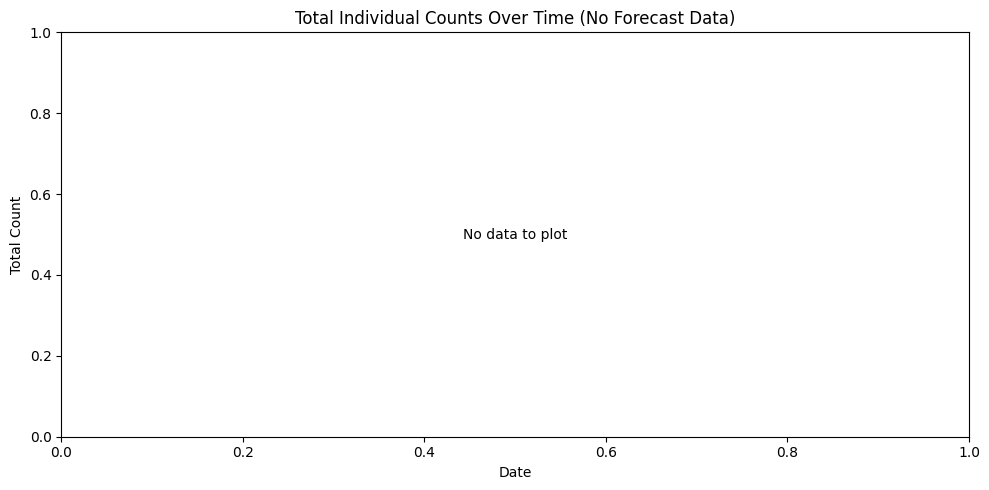

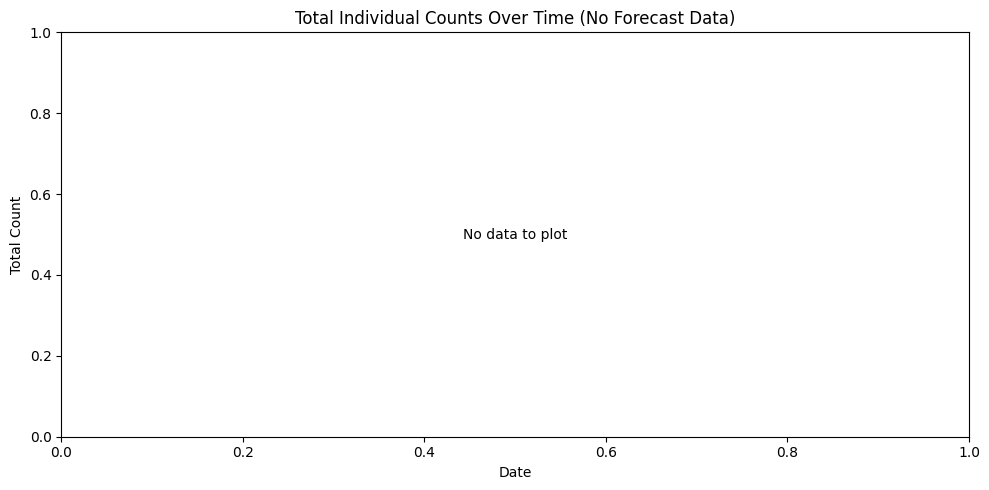

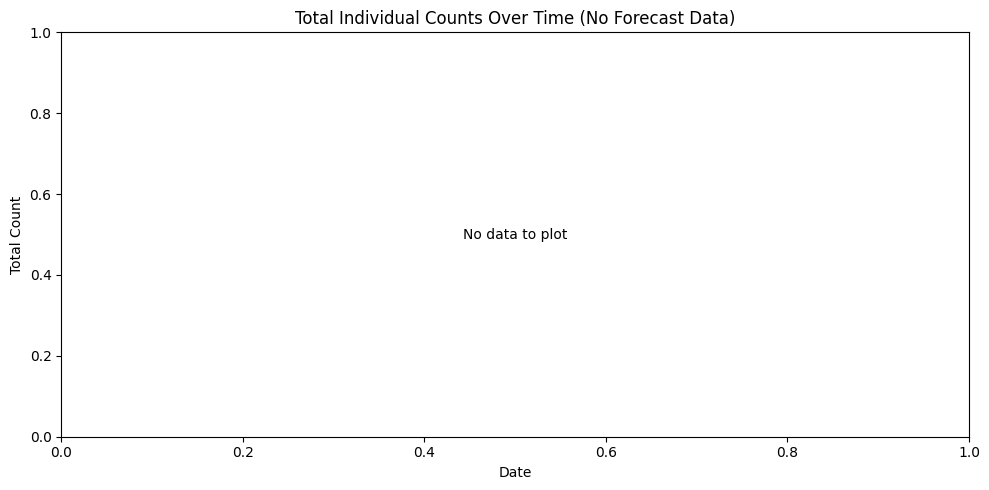

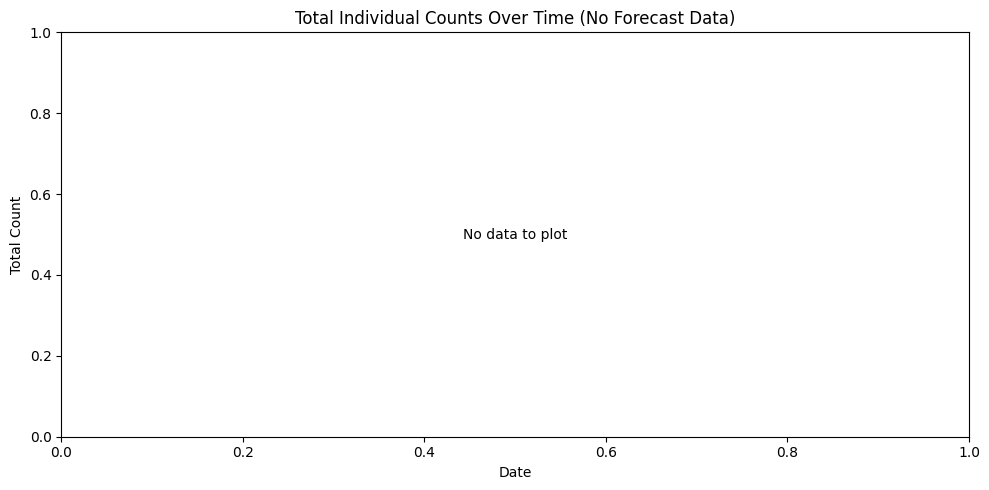

In [160]:
def navigate(screen_name):
    """Controls the visibility of content sections based on the selected screen."""
    return {
        main_content: gr.update(visible=screen_name == "Main"),
        hw2_content: gr.update(visible=screen_name == "HW2"),
        map_content: gr.update(visible=screen_name == "Map"),
        graph_info_content: gr.update(visible=screen_name == "Graph and Info")
    }

def show_historical_map():
    """Shows the historical map container and hides the future map container."""
    return gr.Column(visible=True), gr.Column(visible=False)

def show_future_map():
    """Shows the future map container and hides the historical map container."""
    return gr.Column(visible=False), gr.Column(visible=True)


with gr.Blocks() as full_app:
    with gr.Row():
        main_button = gr.Button("Home")
        map_button = gr.Button("Map")
        graph_info_button = gr.Button("Info")
        hw2_button = gr.Button("Data Analysis")

    # Define content columns with initial visibility
    with gr.Column(visible=True) as main_content:
        gr.Markdown(
            """
            <div style="text-align: center">

            # 🌍EcoKishon🌳
            ### Kishon River Ecological Data Analysis and Forecasting

            Welcome to the Kishon River Ecological Data Analysis and Forecasting application.
            This project explores ecological data from the Kishon River, applies various data
            science techniques to understand patterns, and forecasts future species occurrences.

            ---

            </div>
            """,
            elem_id="centered-markdown"
        )

        image = "https://upload.wikimedia.org/wikipedia/commons/9/98/Park_Kishon%2C_Haifa_023.JPG"
        gr.Image(value=image, type="pil", label="Kishon River", show_label=True, width=512, height=384)

        gr.Markdown(
            """
            <div style="text-align: center">

            ## 🌱 What You Can Do
            - 📊 Explore population data for various species over time
            - 🧠 Graphically display environmental data from the Kishon River
            - 🗺️ Visualize ecological data on interactive maps
            - 🔍 Search for species and view detailed summaries

            </div>

            """,
            elem_id="centered-markdown"
        )


    with gr.Column(visible=False) as hw2_content:
        gr.Markdown("""
            # PCA and Kriging Analysis
            * This page includes some analyses on the **Kishon River ecological data**.
            * The data includes **measurements** in the river and **observations** of species occurrences.

            ## PCA:
            * This analysis is done to reduce the **dimensionality of the data** and identify the **main drivers** of variation in the data.
            * We identified 4 measurements that are the main drivers of variation in the data - **opacity, specific electrical conductivity, coliform bacteria and individuals**.

            ## Kriging:
            * This analysis is done to create **spatial heatmaps** showing predicted values across the **river area** for specific dates.
            * We used **ordinary kriging** to create heatmaps for opacity, specific electrical conductivity and individuals.
        """)

        with gr.Row():
            with gr.Column():
                gr.Markdown("""
                ### PCA Biplot
                * The plot shown here is a **biplot** of the principal components of the data.
                """)
                gr.Plot(biplot_pc1_pc2(), label="PCA Biplot")

            with gr.Column():
                gr.Markdown("""
                ### Correlation Matrix
                * This heatmap shows the correlation between the ecological variables.
                """)
                gr.Plot(correlation_matrix_heatmap(), label="Correlation Matrix Heatmap")

        with gr.Row():
            gr.Markdown("## Summary Tables")

        with gr.Row():
            with gr.Column():
                gr.Markdown("### Individual Counts by Conductivity Bin")
                gr.DataFrame(value=sum_by_conductivity_bin, label="Conductivity Bin Summary")

            with gr.Column():
                gr.Markdown("### Individual Counts by Opacity Bin")
                gr.DataFrame(value=sum_by_opacity_bin, label="Opacity Bin Summary")

        with gr.Row():
            with gr.Column():
                gr.Markdown("### Individual Counts by Coliform Bacteria Bin")
                gr.DataFrame(value=sum_by_coliform_bacteria_bin, label="Coliform Bacteria Bin Summary")

            with gr.Column():
                gr.Markdown("### Binned 3D Data (Conductivity, Opacity, Coliform Bacteria)")
                gr.DataFrame(value=binned_3d_data_sorted_with_individuals, label="3D Binned Data Summary")

        # Add components for the interactive density heatmap
        gr.Markdown("""
            ### Interactive Density Heatmap
            * Select two environmental measures to visualize the density of individual counts.
        """)
        with gr.Row():
            measure_choices = ['coliform_bacteria', 'specific_electrical_conductivity', 'opacity']
            x_measure_dropdown = gr.Dropdown(choices=measure_choices, label="Select X-axis Measure", value='specific_electrical_conductivity')
            y_measure_dropdown = gr.Dropdown(choices=measure_choices, label="Select Y-axis Measure", value='opacity')
        with gr.Row():
            generate_heatmap_button = gr.Button("Generate Density Heatmap")
        with gr.Row():
            density_heatmap_plot = gr.Plot(label="Individual Counts Density Heatmap")

        # Link the button click to the generate_density_heatmap function
        generate_heatmap_button.click(
            fn=generate_density_heatmap,
            inputs=[x_measure_dropdown, y_measure_dropdown],
            outputs=[density_heatmap_plot]
        )


        with gr.Row():
            gr.Markdown("""
                ### Kriging
                * The plots shown here are kriging heatmaps for **opacity, specific electrical conductivity and individuals** for a specific month and year.
                * Use the **sliders** to choose a month and year and the **dropdown** to choose the measurement to show kriging for.
                * Click the **button** to generate the kriging heatmaps.
                ### Notes:
                * We must note that because of **lack of data**, some of the kriging heatmaps may not be generated correctly.
                """)

        with gr.Row():
            month_slider = gr.Slider(minimum=1, maximum=12, value=1, step=1, label="Choose Month")
            year_slider = gr.Slider(minimum=2022, maximum=2024, value=2022, step=1, label="Choose Year")
            measurement_type_dropdown = gr.Dropdown(choices=['individualCount', 'opacity', 'specific_electrical_conductivity'], label="Choose measurement to show kriging for")

        with gr.Row():
            generate_kriging_button = gr.Button("Generate Kriging for measurement")

        with gr.Row():
            kriging_interpolation_plot = gr.Plot(label="Kriging Interpolation Plot")
            kriging_variance_plot = gr.Plot(label="Kriging Variance Plot")

        # Link the button click to the plotting function
        generate_kriging_button.click(
            fn=plot_kriging_for_month_and_year,
            inputs=[measurement_type_dropdown, month_slider, year_slider],
            outputs=[kriging_interpolation_plot, kriging_variance_plot]
        )


    with gr.Column(visible=False) as map_content:
        with gr.Row():
            gr.Markdown("""
              # Kishon River Species Occurrences Map
              * This page includes **two maps**.
              * You can view historical data or future predictions.
            """)

        with gr.Row():
            show_historical_button = gr.Button("Show Historical Map")
            show_future_button = gr.Button("Show Forecast Map")

        with gr.Column(visible=True) as current_map_container:
            gr.Markdown("## Historical Data Map")
            with gr.Row():
                # Adjust historical year range based on data
                min_hist_year = 2022
                max_hist_year = 2025
                month_slider_hist = gr.Slider(label="Month", minimum=1, maximum=12, value=integrated_df.index[-1].month if not integrated_df.empty else 1, step=1)
                year_slider_hist = gr.Slider(label="Year", minimum=min_hist_year, maximum=max_hist_year, value=integrated_df.index[-1].year if not integrated_df.empty else 2022, step=1)
            with gr.Row():
                generate_map_button_hist = gr.Button("Generate Historical Map")
            with gr.Row():
                map_html_hist = gr.HTML(label="Historical Map Display")
                plot_component_hist = gr.Plot(label="Historical Total Counts Over Time")

            generate_map_button_hist.click(
                fn=create_map_per_month_and_year,
                inputs=[month_slider_hist, year_slider_hist],
                outputs=[map_html_hist, plot_component_hist]
            )

        with gr.Column(visible=False) as future_map_container:
            current_datetime = datetime.now()
            gr.Markdown("## Future Forecast Map")
            with gr.Row():
                month_slider_future = gr.Slider(label="Month", minimum=1, maximum=12, value=(current_datetime.month + 1) if current_datetime.month < 12 else 1, step=1)
                year_slider_future = gr.Slider(label="Year", minimum=current_datetime.year, maximum=(current_datetime.year + 3), value=current_datetime.year if current_datetime.month < 12 else current_datetime.year + 1, step=1)
            with gr.Row():
                generate_map_button_future = gr.Button("Generate Forecast Map")
            with gr.Row():
                map_html_future = gr.HTML(label="Future Map Display")
                plot_component_future = gr.Plot(label="Combined Historical & Forecasted Total Counts Plot")

            generate_map_button_future.click(
                fn=create_future_map_per_month_and_year,
                inputs=[month_slider_future, year_slider_future],
                outputs=[map_html_future, plot_component_future]
            )

        # Link new buttons to show/hide map containers
        show_historical_button.click(
            fn=show_historical_map,
            inputs=[],
            outputs=[current_map_container, future_map_container]
        )
        show_future_button.click(
            fn=show_future_map,
            inputs=[],
            outputs=[current_map_container, future_map_container]
        )


    with gr.Column(visible=False) as graph_info_content:
      gr.Markdown("## 🌱 Graph and Info Dashboard")

      with gr.Row():
        start_year = gr.Slider(minimum=2022, maximum=2024, label="Start Year", value=2022, step=1)
        end_year = gr.Slider(minimum=2022, maximum=2024, label="End Year", value=2024, step=1)
        start_month = gr.Slider(minimum=1, maximum=12, label="Start Month", value=1, step=1)
        end_month = gr.Slider(minimum=1, maximum=12, label="End Month", value=12, step=1)

      with gr.Row():
        station_dropdown = gr.Dropdown(choices=station_list_str, label="Choose a Station", allow_custom_value=False, filterable=True)

      with gr.Row():
        plot_btn = gr.Button("Generate Graph")

      with gr.Row():
        graph_output = gr.Plot()

      plot_btn.click(fn=generate_plot,
                    inputs=[start_year, end_year, start_month, end_month, station_dropdown],
                    outputs=graph_output)

      with gr.Row():
        gr.Markdown("### 🐾 Search for a Species")

      with gr.Row():
        species_dropdown = gr.Dropdown(choices=species_list, label="Choose a Species", allow_custom_value=False, filterable=True)

      with gr.Row():
        info_title = gr.Textbox(label="Name", interactive=False)

      with gr.Row():
        with gr.Column():
          with gr.Row():
            info_image = gr.Image(label="Image")
          with gr.Row():
            info_summary = gr.Textbox(label="Summary", lines=5, interactive=False)
        with gr.Column():
          species_map_html = gr.HTML(label="Species Map")


      # Update the change function for the species dropdown to also update the map
      species_dropdown.change(
          fn=update_graph_info_content,
          inputs=species_dropdown,
          outputs=[info_title, info_image, info_summary, species_map_html]
      )

      full_app.load(update_graph_info_content, inputs=species_dropdown, outputs=[info_title, info_image, info_summary, species_map_html])


    # Link navigation buttons to the navigate function
    main_button.click(
        fn=navigate,
        inputs=gr.State("Main"),
        outputs=[main_content, hw2_content, map_content, graph_info_content],
    )
    hw2_button.click(
        fn=navigate,
        inputs=gr.State("HW2"),
        outputs=[main_content, hw2_content, map_content, graph_info_content],
    )
    map_button.click(
        fn=navigate,
        inputs=gr.State("Map"),
        outputs=[main_content, hw2_content, map_content, graph_info_content],
    )
    graph_info_button.click(
        fn=navigate,
        inputs=gr.State("Graph and Info"),
        outputs=[main_content, hw2_content, map_content, graph_info_content],
    )


full_app.launch()